In [3]:
import numpy as np
from scipy import sparse
import torch as T
import torch

def normalize(mat):
	"""mat gets row-normalized"""
	row_sum = np.array(mat.sum(1)) + 1e-5
	reciprocal = np.reciprocal(row_sum).flatten()
	reciprocal[np.isinf(reciprocal)] = 0
	reciprocal_mat = sparse.diags(reciprocal)
	return reciprocal_mat.dot(mat)

def get_sparse_tensor(mat):
	mat = mat.tocoo().astype(np.float32)
	indices = T.from_numpy(
		np.vstack((mat.row, mat.col)).astype(np.int64)
	)
	values = T.from_numpy(mat.data)
	return T.sparse.FloatTensor(indices, values, T.Size(mat.shape))

def parse_data(dataset, verbose=True):

    x = []
    with open('../data/{}/{}.txt'.format(dataset, 'feature'), 'r') as f:
        lines = f.readlines()
    for line in lines:
        row = line.strip().split('\t')
        row = [int(item) for item in row]
        x.append(row)
    x = T.from_numpy(normalize(np.array(x)))

    y = []
    with open('../data/{}/{}.txt'.format(dataset, 'group'), 'r') as f:
        lines = f.readlines()
    for line in lines:
        row = line.strip().split('\t')
        row = int(row[1])
        y.append(row)
    y = np.array(y)

    E = []
    with open('../data/{}/{}.txt'.format(dataset, 'graph'), 'r') as f:
        lines = f.readlines()
    for line in lines:
        row = line.strip().split('\t')
        u = int(row[0])
        v = int(row[1])
        E.append([u, v])
    E = np.array(E)
    A = sparse.coo_matrix(
        (np.ones(E.shape[0]), (E[:, 0], E[:, 1])),
        (len(y), len(y)),
        np.float32
    )
    A += A.T.multiply(A.T > A) - A.multiply(A < A.T) #? logic
    A = normalize(A + sparse.eye(len(y)))
    A = get_sparse_tensor(A)
    if verbose:
        print("#Edges:", len(lines))
        print("#Classes:", y.max() + 1)
    
    return x, A, y

In [4]:
x, A, y = parse_data('cora')
unique, counts = np.unique(y, return_counts=True)

print(x.shape)
print(A.shape)
print(y.shape)

dict(zip(unique, counts))

#Edges: 5429
#Classes: 7
torch.Size([2708, 1433])
torch.Size([2708, 2708])
(2708,)


{0: 818, 1: 180, 2: 217, 3: 426, 4: 351, 5: 418, 6: 298}

In [3]:
x, A, y = parse_data('citeseer')
unique, counts = np.unique(y, return_counts=True)

print(x.shape)
print(A.shape)
print(y.shape)

dict(zip(unique, counts))

#Edges: 4732
#Classes: 6
torch.Size([3312, 3703])
torch.Size([3312, 3312])
(3312,)


{0: 596, 1: 668, 2: 701, 3: 249, 4: 508, 5: 590}

# PU Loss

In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class PULoss(nn.Module):
    def __init__(self, prior=torch.tensor(0.5), loss=nn.SoftMarginLoss(reduction='none'), beta=0, nnpu=True) -> None:
        super().__init__()
        self.prior = prior.cuda()
        self.beta = beta
        self.loss_func = loss
        self.nnpu = nnpu
        self.positive = 1
        self.unlabelled = 0
        self.min_count = torch.tensor(1.)

    def forward(self, inp, target):
        positive, unlabelled = target == self.positive, target == self.unlabelled
        positive, unlabelled = positive.type(torch.float), unlabelled.type(torch.float)
        n_pos, n_unlb = torch.max(self.min_count, torch.sum(positive)),\
             torch.max(self.min_count, torch.sum(unlabelled))
        
        y_pos = self.loss_func(inp, torch.ones_like(target)) * positive
        # y_pos_inv = self.loss_func(inp, torch.zeros_like(target)) * positive
        y_pos_inv = self.loss_func(inp, -torch.ones_like(target)) * positive

        # y_unlabelled = self.loss_func(inp, torch.zeros_like(target)) * unlabelled
        y_unlabelled = self.loss_func(inp, -torch.ones_like(target)) * unlabelled


        positive_risk = self.prior * torch.sum(y_pos) / n_pos
        negative_risk = torch.sum(y_unlabelled) / n_unlb - self.prior * torch.sum(y_pos_inv) / n_pos

        if self.nnpu and negative_risk < -self.beta:
            return positive_risk
        else:
            return positive_risk + negative_risk

# GCN

In [3]:
class GraphConvolution(Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout=0.5):
        super().__init__()

        self.gc1 = GraphConvolution(nfeat, nhid)
        self.gc2 = GraphConvolution(nhid, nclass)
        self.fc = nn.Linear(nclass, 1)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gc1(x, adj))
        x = F.dropout(x, self.dropout, training=self.training) #TODO: no dropout
        x = F.relu(self.gc2(x, adj))
        x = torch.sigmoid(self.fc(x))
        return x

In [10]:
def make_binary(y, class_label, p):
    mask = y == class_label
    y_binary_test = mask.astype(int)
    y_binary_train = np.zeros_like(y_binary_test)
    P = np.nonzero(mask)[0]
    N = np.nonzero(~mask)[0]
    k = len(P)
    N_equal = np.random.choice(N, k, False)
    indices = np.concatenate((P, N_equal))
    P_train = np.random.choice(P, int(k * p), False) #TODO: check ceil/floor
    y_binary_train[P_train] = 1

    np.random.shuffle(indices)
    indices = torch.from_numpy(indices)
    y_binary_train = torch.from_numpy(y_binary_train)
    y_binary_test = torch.from_numpy(y_binary_test)

    return indices, y_binary_train, y_binary_test

In [11]:
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from sklearn.metrics import f1_score 

N_ITER = 10
seeds = np.random.randint(1000, size=N_ITER) 
f1_scores_global = []


def get_table(
    nnpu = False,
    p = 0.01,
    dataset = 'cora',
    class_label = 3,
    verbose = False,
    eps = 1e-2
):
    x_, A_, y_ = parse_data(dataset, False)
    for _ in range(1):
        f1_scores = []
        for i in range(N_ITER):


            np.random.seed(seeds[i])
            model = GCN(nfeat=x_.shape[1],
                nhid=64,
                nclass=2).to("cuda")

            def train(epoch, verbose=False, nnpu=False):
                model.train()
                optimizer.zero_grad()
                output = model(x, A)
                criterion = PULoss(nnpu=nnpu)
                loss = criterion(output[indices].view(-1), y_binary_train[indices]) # !CHECK
                loss.backward()
                optimizer.step()
                if verbose:
                    print('Epoch: {}\tLoss:{}'.format(epoch, loss.item()))
                return loss.item()

            def test(verbose=True, nnpu=False):
                model.eval()
                output = model(x, A)
                criterion = PULoss(nnpu=nnpu)
                loss = criterion(output[indices].view(-1), y_binary_test[indices])
                pred = torch.where(output < 0.5, torch.tensor(0, device=device), 
                    torch.tensor(1, device=device))
                f1 = f1_score(y_binary_test[indices].cpu(), pred[indices].cpu())
                if verbose:
                    print('f1:{}\tLoss:{}'.format(f1, loss.item()))
                return f1

           
            indices, y_binary_train, y_binary_test = make_binary(y_, class_label, p)
            x = x_.cuda().float()
            A = A_.cuda().float()
            y = T.from_numpy(y_).cuda().float()
            indices = indices.cuda()
            y_binary_train = y_binary_train.cuda().float()
            y_binary_test = y_binary_test.cuda().float()
            device = torch.device("cuda")
            
            optimizer = optim.Adam(model.parameters(), lr=1e-4)

            num_epochs = 1000
            epoch = 1
            prev_loss = 1e10
            while True:
                cur_loss = train(epoch, False, nnpu)
                if abs(prev_loss - cur_loss) < eps: break
                prev_loss = cur_loss
                epoch += 1

            f1_scores.append(test(verbose, nnpu))  

        print(p, np.mean(f1_scores),'±' ,np.std(f1_scores))
        # f1_scores_global.append(np.mean(f1_scores))
    # print("global", np.mean(f1_scores_global),'±' ,np.std(f1_scores_global))

In [12]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 1/100,
        dataset = 'cora',
        class_label = 3,
        verbose = False,
        eps=1e-3
    )

0.01 0.2 ± 0.30550504633038933
0.01 0.3333333333333333 ± 0.33333333333333337
0.01 0.4666666666666667 ± 0.30550504633038933
0.01 0.33604213694507146 ± 0.3307132906154237
0.01 0.3333333333333333 ± 0.33333333333333337


In [13]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 2/100,
        dataset = 'cora',
        class_label = 3,
        verbose = False,
        eps=1e-4
    )

0.02 0.5333333333333334 ± 0.26666666666666666
0.02 0.2668235294117647 ± 0.3267910315722148
0.02 0.34412790788629716 ± 0.32357473512299917
0.02 0.26666666666666666 ± 0.3265986323710904
0.02 0.5333333333333334 ± 0.26666666666666666


In [18]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 1/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.01 0.3333333333333333 ± 0.33333333333333337
0.01 0.13298195176489377 ± 0.265965064107742
0.01 0.39999999999999997 ± 0.3265986323710904
0.01 0.36843082636954494 ± 0.31432354123919143
0.01 0.3333333333333333 ± 0.33333333333333337


In [19]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 2/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.02 0.26666666666666666 ± 0.3265986323710904
0.02 0.3328130081300813 ± 0.3328162620532997
0.02 0.13333333333333333 ± 0.26666666666666666
0.02 0.32717086834733894 ± 0.327634834675406
0.02 0.39919523579591176 ± 0.32594982420607405


In [20]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 3/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.03 0.5317734825364531 ± 0.26592677396077746
0.03 0.3333333333333333 ± 0.33333333333333337
0.03 0.4666666666666666 ± 0.30550504633038933
0.03 0.2 ± 0.30550504633038933
0.03 0.26666666666666666 ± 0.3265986323710904


In [21]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 4/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.04 0.39999999999999997 ± 0.3265986323710904
0.04 0.3333333333333333 ± 0.33333333333333337
0.04 0.2666032350142721 ± 0.3265209909897398
0.04 0.3333333333333333 ± 0.33333333333333337
0.04 0.2 ± 0.30550504633038933


In [23]:
for i in range(1, 6):
    get_table(
        nnpu = False,
        p = 5/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.05 0.26666666666666666 ± 0.3265986323710904
0.05 0.39999999999999997 ± 0.3265986323710904
0.05 0.26666666666666666 ± 0.3265986323710904
0.05 0.32938304482911673 ± 0.32957249347455
0.05 0.3333333333333333 ± 0.33333333333333337


In [24]:
for i in range(1, 6):
    get_table(
        nnpu = True,
        p = 1/100,
        dataset = 'citeseer',
        class_label = 2,
        verbose = False,
        eps=1e-3
    )

0.01 0.4 ± 0.3265986323710904
0.01 0.3333333333333333 ± 0.33333333333333337
0.01 0.3333333333333333 ± 0.33333333333333337
0.01 0.3331427057548713 ± 0.33314299037944195
0.01 0.4666666666666666 ± 0.30550504633038933


# GAT

data:citeseer nnpu:True, p:1, ['0.01', '0.6844048551899551', '±', '0.017630260106033534'], [True, True, 4]
nnpu over
data:citeseer nnpu:True, p:2, ['0.02', '0.7233358166646924', '±', '0.032814867394407865'], [True, False, 1]
nnpu over
data:citeseer nnpu:True, p:3, ['0.03', '0.7293239402157405', '±', '0.016964037363108007'], [True, False, 1]
nnpu over
data:citeseer nnpu:True, p:4, ['0.04', '0.755731010012608', '±', '0.01849227600641478'], [True, False, 2]
nnpu over
data:citeseer nnpu:True, p:5, ['0.05', '0.7653634457209793', '±', '0.02225639973685271'], [True, False, 2]
nnpu over
data:citeseer nnpu:False, p:1, ['0.01', '0.6666666666666667', '±', '1.1102230246251565e-16'], [True, True, 9]
nnpu over
data:citeseer nnpu:False, p:2, ['0.02', '0.6666666666666667', '±', '1.1102230246251565e-16'], [True, True, 9]
nnpu over
data:citeseer nnpu:False, p:3, ['0.03', '0.6737942970636964', '±', '0.054802369275814895'], [True, True, 1]
nnpu over
data:citeseer nnpu:False, p:4, ['0.04', '0.7012141910451

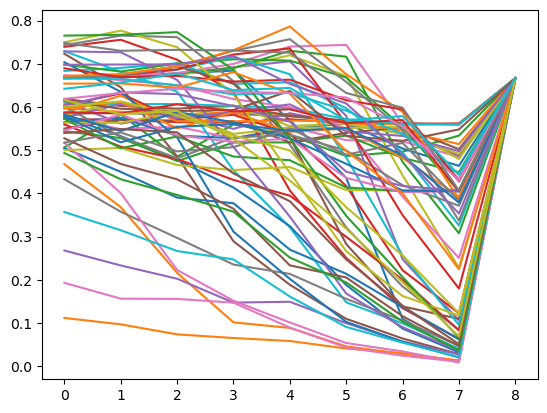

In [31]:
import matplotlib.pyplot as plt
loc = "../op_file.txt"
with open(loc, "r") as f:
    lines = f.readlines()[24:]

index = 1
for data in ['citeseer', 'cora']:
    for nnpu in [True, False]:
        for p_ in range(1, 6):
            mx = 0
            best = None
            config = None
            for bias in [True, False]:  
                for add_skip_connection in [True, False]:
                    vals = []
                    if lines[index].split()[1] == "main.py":
                        index += 36
                        continue
                    for d in range(1, 10):
                        cur = lines[index].split()
                        vals.append(float(cur[1]))
                        if mx < float(cur[1]): 
                            mx = float(cur[1])
                            config = [bias, add_skip_connection, d]
                            best =  cur
                        index += 2
                    plt.plot(vals)
            print("data:{} nnpu:{}, p:{}, {}, {}".format(data, nnpu, p_, best, config))
            print("nnpu over")

                            


In [17]:
import torch
NH = 2
FOUT = 2
N = 2
ss = torch.rand(1, NH, FOUT)
H = torch.rand(N, NH, FOUT)


In [20]:
FIN = 4
in_nodes_features = torch.rand(1, N, FIN)
proj = torch.rand(NH, FIN, FOUT)
torch.matmul(in_nodes_features, proj).shape

torch.Size([2, 2, 2])

In [15]:
import matplotlib.pyplot as plt
loc = "../op_file.txt"
with open(loc, "r") as f:
    lines = f.readlines()[384:]

index = 1
for data in ['citeseer', 'cora']:
    for nnpu in [True, False]:
        for p_ in range(1, 6):
            mx = 0
            best = None
            config = None
            for bias in [True, False]:  
                for add_skip_connection in [True, False]:
                    vals = []
                    for d in range(1, 10):
                        cur = lines[index].split()
                        vals.append(float(cur[1]))
                        if mx < float(cur[1]): 
                            mx = float(cur[1])
                            config = [bias, add_skip_connection, d]
                            best =  cur
                        index += 2
                    plt.plot(vals)
            print("data:{} nnpu:{}, {}, {}".format(data, nnpu, best, config))


                            


tensor([[[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True]]])

In [1]:
from data_loading import parse_data, make_binary

dataset = 'cora'
x_, edge_index_, y_ = parse_data(dataset)
indices, y_binary_train, y_binary_test = make_binary(y_, 3, 0.01)


In [2]:
x_.sum(axis=0)

tensor([0.7399, 1.6961, 3.4994,  ..., 0.3656, 3.2537, 0.6146],
       dtype=torch.float64)

In [3]:
x_.sum(axis=1)


tensor([1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
       dtype=torch.float64)